<a href="https://colab.research.google.com/github/vanha2301/AIR/blob/main/feature_selection_overfitting_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Giảm Overfitting bằng Chọn Đặc Trưng: Filter • Wrapper • Embedded

Notebook này minh hoạ **3 nhóm phương pháp** chọn đặc trưng và tác động của chúng tới overfitting:

- **Filter**: đánh giá đặc trưng độc lập với mô hình (ví dụ: F-test).
- **Wrapper**: sử dụng một mô hình để "bọc" và tìm tập đặc trưng tốt (ví dụ: RFE).
- **Embedded**: mô hình tự học trọng số/độ quan trọng rồi loại bớt (ví dụ: Logistic L1).

Chúng ta dùng bộ dữ liệu tổng hợp có nhiều nhiễu để dễ thấy overfitting.


In [1]:

# !pip install scikit-learn matplotlib --quiet

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [2]:

# Dữ liệu tổng hợp: nhiều đặc trưng nhiễu để dễ overfit
X, y = make_classification(
    n_samples=500,
    n_features=150,
    n_informative=12,
    n_redundant=8,
    n_clusters_per_class=2,
    flip_y=0.02,
    class_sep=1.0,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((350, 150), (150, 150))

In [9]:

def fit_eval(pipe, name):
    pipe.fit(X_train, y_train)
    y_tr = pipe.predict(X_train)
    y_te = pipe.predict(X_test)
    train_acc = accuracy_score(y_train, y_tr)
    test_acc  = accuracy_score(y_test, y_te)
    nfeat = None
    if "selector" in pipe.named_steps and hasattr(pipe.named_steps["selector"], "get_support"):
        nfeat = int(pipe.named_steps["selector"].get_support().sum())
    elif "rfe" in pipe.named_steps and hasattr(pipe.named_steps["rfe"], "support_"):
        nfeat = int(pipe.named_steps["rfe"].support_.sum())
    else:
        nfeat = X_train.shape[1]
    print(f"{name:35s} | train={train_acc:.3f} | test={test_acc:.3f} | #feat={nfeat}")
    return {"method": name, "train_acc": train_acc, "test_acc": test_acc, "n_features": nfeat}


## 1) Baseline (không chọn đặc trưng)

In [4]:

baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, solver="lbfgs"))
])
res_baseline = fit_eval(baseline, "Baseline (no FS)")


Baseline (no FS)                    | train=0.986 | test=0.660 | #feat=150


## 2) Filter — SelectKBest (F-test)

Filter: SelectKBest(F), k=5         | train=0.794 | test=0.753 | #feat=5
Filter: SelectKBest(F), k=10        | train=0.777 | test=0.753 | #feat=10
Filter: SelectKBest(F), k=20        | train=0.820 | test=0.767 | #feat=20
Filter: SelectKBest(F), k=40        | train=0.886 | test=0.747 | #feat=40
Filter: SelectKBest(F), k=60        | train=0.906 | test=0.707 | #feat=60
Filter: SelectKBest(F), k=80        | train=0.923 | test=0.673 | #feat=80


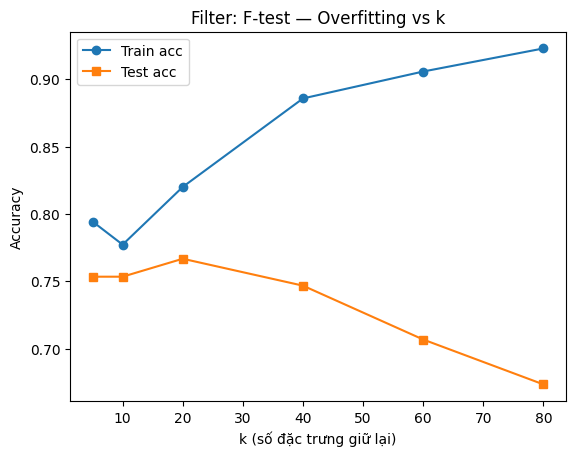

In [5]:

results = []
for k in [5, 10, 20, 40, 60, 80]:
    pipe = Pipeline([
        ("selector", SelectKBest(score_func=f_classif, k=k)),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, solver="lbfgs"))
    ])
    results.append(fit_eval(pipe, f"Filter: SelectKBest(F), k={k}"))

# Vẽ nhanh đường cong train/test theo k
ks = [r["n_features"] for r in results]
tr = [r["train_acc"] for r in results]
te = [r["test_acc"] for r in results]

plt.figure()
plt.plot(ks, tr, marker="o", label="Train acc")
plt.plot(ks, te, marker="s", label="Test acc")
plt.xlabel("k (số đặc trưng giữ lại)")
plt.ylabel("Accuracy")
plt.title("Filter: F-test — Overfitting vs k")
plt.legend()
plt.show()


## 3) Wrapper — RFE với LogisticRegression

In [6]:

results_rfe = []
for k in [5, 10, 20, 40]:
    rfe = RFE(estimator=LogisticRegression(max_iter=1000, solver="lbfgs"), n_features_to_select=k, step=0.2)
    pipe = Pipeline([
        ("rfe", rfe),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, solver="lbfgs"))
    ])
    results_rfe.append(fit_eval(pipe, f"Wrapper: RFE(LogReg), k={k}"))


Wrapper: RFE(LogReg), k=5           | train=0.757 | test=0.747 | #feat=5
Wrapper: RFE(LogReg), k=10          | train=0.820 | test=0.700 | #feat=10
Wrapper: RFE(LogReg), k=20          | train=0.829 | test=0.687 | #feat=20
Wrapper: RFE(LogReg), k=40          | train=0.909 | test=0.653 | #feat=40


## 4) Embedded — Logistic Regression L1 (tự loại bớt đặc trưng)

In [7]:

embedded = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, penalty="l1", solver="liblinear", C=1.0))
])
res_emb = fit_eval(embedded, "Embedded: Logistic L1")

# Đếm số đặc trưng có hệ số khác 0
embedded.fit(X_train, y_train)
coef = embedded.named_steps["clf"].coef_.ravel()
n_nonzero = int((coef != 0).sum())
print("Số đặc trưng có trọng số khác 0 (ước lượng):", n_nonzero)


Embedded: Logistic L1               | train=0.983 | test=0.700 | #feat=150
Số đặc trưng có trọng số khác 0 (ước lượng): 114


## 5) Kết luận nhanh


- **Filter (F-test)**: nhanh, không phụ thuộc mô hình, hiệu quả khi chọn *k* hợp lý.
- **Wrapper (RFE)**: thường cho chất lượng tốt hơn nhưng tốn thời gian hơn.
- **Embedded (L1)**: mô hình tự chọn, gọn gàng và thường tổng quát tốt.
  
Chọn *k* bằng cross-validation sẽ đáng tin cậy hơn. Trên dữ liệu thực, hãy kết hợp thêm regularization/early-stopping.
